# Focused Gaussian beam waist

Given an optical imaging system with effective focal length $f$, how does the beam waist at the geometrical focus behave in dependence of the beam wave of the inciden Gaussian beam.

In [1]:
import numpy as np
import mpmath as mp

from optics.beam import GaussianBeam
from optics.geometrical import ThinLens, Propagation
from optics.diffraction import UreyDiffraction, LiDiffraction

from matplotlib import pyplot as plt

colors = plt.get_cmap('tab20c').colors

These are the fixed system parameters.

In [2]:
# aperture radius
a = 20e-3

# focal length
f = 25e-3

# wavelength
λ = 532e-9

# numerical aperture
NA = 0.8

## Beam waist at focal spot

In a first part we will estimate the spot size radius of the focused Gaussian beams from different approximations.
The first approximation arises from the ray transfer matrix formalism [[1]]. The ray transfer matrix is constructed from a thin lens following a free space propagation.

[1]: https://en.wikipedia.org/wiki/Ray_transfer_matrix_analysis

In [3]:
ML = ThinLens(f).abcd()

print(ML)

[  1.0  0.0]
[-40.0  1.0]


In [4]:
MP = Propagation(f).abcd()

print(MP)

[1.0  0.025]
[0.0    1.0]


In [5]:
M = MP * ML

Using the complex beam parameter, one can use the ray transfer matrix formalism for the propagation of Gaussian beams [[2]]. The complex beam parameter is defined by
$$q(z)=(z-z_0)+iz_R,$$
wherein $z_R$ denotes the Rayleigh length. The reciprocal of the complex beam parameter is often written in terms of the beam waist $w(z)$ and radius of curvature $R(z)$,
$$\frac{1}{q(z)}=\frac{1}{R(z)}-\frac{i\lambda}{\pi w^2(z)}.$$
According to [[1]] ray transfer matrix formalism can be used with Gaussian beams when the complex beam parameter is updated according to $$q^\prime=\frac{Aq+B}{Cq+D},$$ wherein $A,B,C,D$ denote the matrix elements of the transfer matrix of the optical system. In our implementation we return a new Gaussian beam which origin $z_0$ is shifted according to $\operatorname{Re}(q^\prime)$ in order to reflect the change in curvature. The beam waist, however, is replaced by its new value in $\operatorname{Im}(q^\prime)$.

[2]: https://en.wikipedia.org/wiki/Ray_transfer_matrix_analysis#Ray_transfer_matrices_for_Gaussian_beams

In [6]:
def focus_waist_ray(waist):
    return GaussianBeam(waist=waist, wavelength=λ).propagate(M).waist()

Drege [[3]] reports the analytical expression,
$$
\frac{0.97\lambda}{4T \mathit{NA}}\sqrt{\frac{1}{1-\exp(-1/T^2)}-1},
$$
to describe the focus beam waist of aperture limited imaging, wherein $T=w/a$ denotes the truncation parameter as ratio between the beam waist and the aperture radius.

[3]: https://www.osapublishing.org/ao/abstract.cfm?uri=ao-39-27-4918

In [7]:
def focus_waist_drege(waist):
    T = waist / a
    
    return 0.97 * λ * mp.sqrt(mp.exp(1) / (1 - mp.exp(-1 / T**2)) - 1) / (4 * NA * T)

Urey [[4]] reports empirical obtained approximations for an aperture limited beam waist
$$
\begin{align}
&\frac{\lambda}{4\mathit{NA}}\frac{1.27}{T} &(T<0.5) \\
&\frac{\lambda}{4\mathit{NA}}\left(1.654-\frac{0.105}{T}+\frac{0.28}{T^2}\right) &(T>0.4)
\end{align}.
$$

[4]: https://www.osapublishing.org/ao/abstract.cfm?uri=ao-43-3-620

In [8]:
def focus_waist_urey1(waist):
    T = waist / a
    
    return 1.27 * λ / (4 * NA * T)

def focus_waist_urey2(waist):
    T = waist / a
    
    return λ / (4 * NA * T) * (1.654 - 0.105 / T + 0.28 / T**2)

We need to vectorize these functions to allow vector inputs for multiple waists.

In [9]:
focus_waist_ray = np.vectorize(focus_waist_ray)
focus_waist_drege = np.vectorize(focus_waist_drege)
focus_waist_urey1 = np.vectorize(focus_waist_urey1)
focus_waist_urey2 = np.vectorize(focus_waist_urey2)

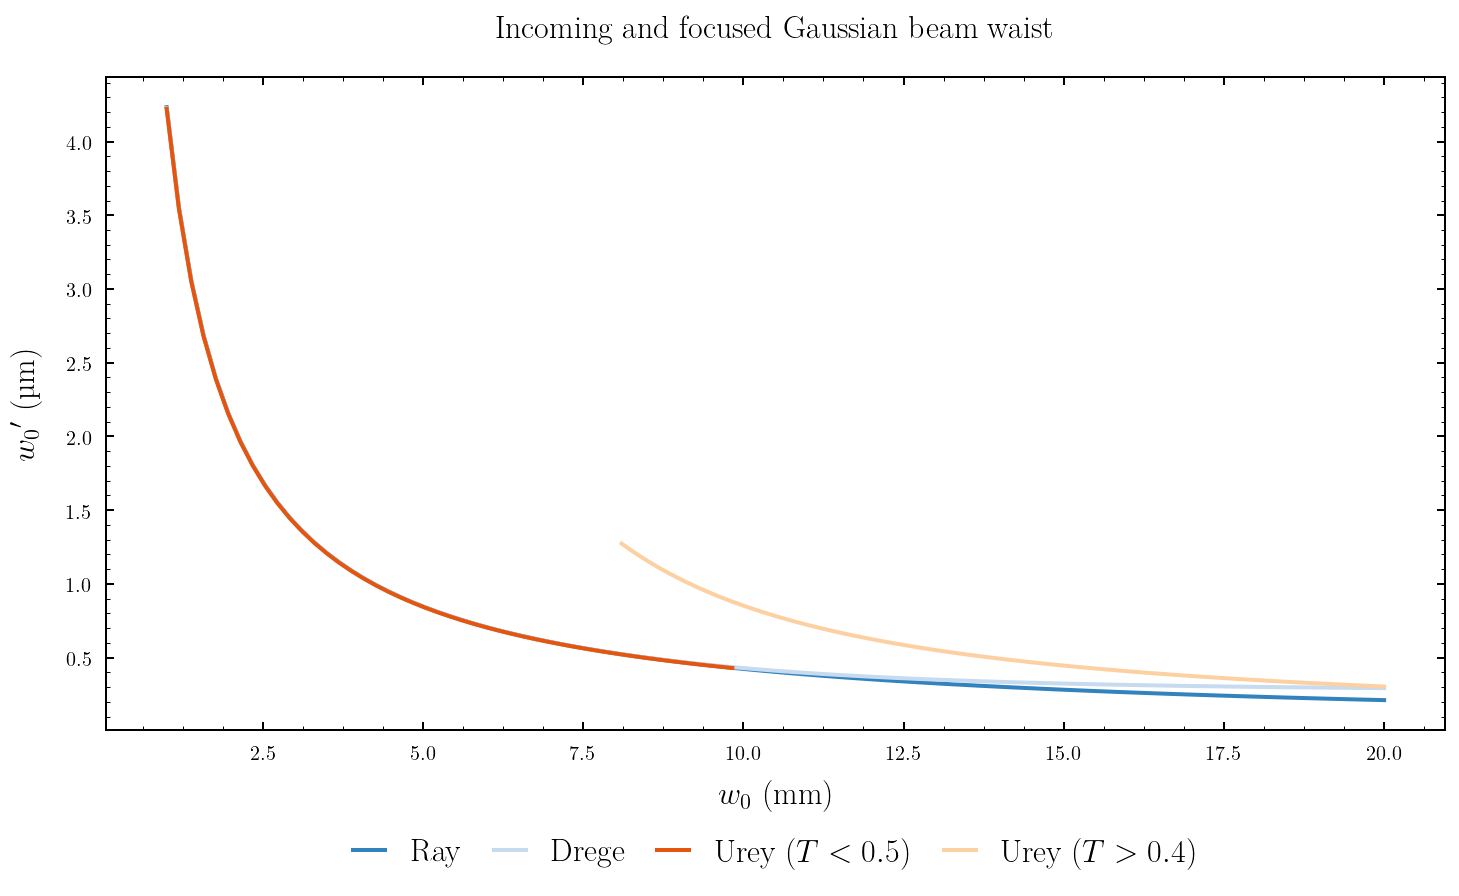

In [10]:
w = np.linspace(1e-3, 20e-3, 100)

plt.figure(figsize=(12, 6))

plt.title(r'Incoming and focused Gaussian beam waist')
plt.xlabel(r'$w_0$ (\si{\milli\meter})')
plt.ylabel(r'${w_0}^\prime$ (\si{\micro\meter})')

plt.plot(w / 1e-3, focus_waist_ray(w) / 1e-6, label='Ray', color=colors[0])
plt.plot(w / 1e-3, focus_waist_drege(w) / 1e-6, label='Drege', color=colors[3])
plt.plot(w[w < 10e-3] / 1e-3, focus_waist_urey1(w[w < 10e-3]) / 1e-6, label=r'Urey $(T<0.5)$', color=colors[4])
plt.plot(w[w > 8e-3] / 1e-3, focus_waist_urey2(w[w > 8e-3]) / 1e-6, label=r'Urey $(T>0.4)$', color=colors[7])

plt.legend(loc='upper center', bbox_to_anchor=(.5, -0.12), ncol=4)
plt.show()

We conclude that the spot size near the focus spot decreases with increasing incident beam waist. As we strive for a small focus spot, we need to find out at what incident beam waist diffraction effects get dominant and limit our resolution.